# Sentiment Analysis
- NCCU PyDay 2022: https://www.facebook.com/groups/pythontw/posts/10162007038723438/
- Author: TENG-LIN YU
- Email: tlyu0419@gmail.com
- Github: https://github.com/TLYu0419/Stock-Prediction-Using-Facebook-Sentiment-with-Python

## Import packages

In [1]:
# !pip install jieba
# !pip install snownlp
# !pip install nltk
# !pip install translate
# !pip install seaborn

In [6]:
import pandas as pd
import numpy as np
import os
import re
import jieba
import requests
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from snownlp import SnowNLP
from translate import Translator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

sns.set(rc={'figure.figsize':(16.7,8.27)})

## Load data

In [7]:
path = '/home/tlyu0419/github/facebook_crawler/develop/data/'
os.listdir(path)

['20220414_ezmoney.tw.pkl',
 '20220418_smart16888.pkl',
 '20220418_smartmonthly.pkl',
 '20220414_emily0806.pkl',
 '20220418_imoneymagazine.pkl',
 '20220414_BToday.pkl',
 '20220414_moneyweekly.tw.pkl',
 '20220414_StockOldBull.pkl',
 '20220418_YahooTWFinance.pkl',
 '20220414_smart16888.pkl',
 '20220414_imoneymagazine.pkl',
 '20220418_emily0806.pkl',
 '20220418_MoneyDJ.pkl',
 '20220414_GreenHornFans.pkl',
 '20220418_ec.ltn.tw.pkl',
 '20220418_ezmoney.tw.pkl',
 '20220414_MoneyMoneyMeg.pkl',
 '20220418_MoneyMoneyMeg.pkl',
 '20220414_edigest.pkl',
 '.ipynb_checkpoints',
 '20220414_cmoneyapp.pkl',
 '20220418_Gooaye.pkl',
 '20220418_cmoneyapp.pkl',
 '20220414_smartmonthly.pkl',
 '20220418_edigest.pkl',
 '20220414_Gooaye.pkl',
 '20220414_ebcmoney.pkl',
 '20220418_GreenHornFans.pkl',
 '20220418_imoney889.pkl',
 '20220418_ebcmoney.pkl',
 '20220414_MoneyDJ.pkl',
 '20220414_ec.ltn.tw.pkl',
 '20220418_StockOldBull.pkl',
 '20220418_wealth1974.pkl',
 '20220414_wealth1974.pkl',
 '20220418_moneyweekly.t

In [12]:
df = pd.DataFrame()
for file in os.listdir(path):
    if 'pkl' in file:
        # print(file)
        ndf = pd.read_pickle(path + file)
        df = pd.concat([df, ndf], ignore_index=True)
        df = df.sort_values('UPDATETIME', ascending=False)
        df = df.drop_duplicates('POSTID', ignore_index=True)
print(df.shape)
df.head(5)

20220414_ezmoney.tw.pkl
20220418_smart16888.pkl
20220418_smartmonthly.pkl
20220414_emily0806.pkl
20220418_imoneymagazine.pkl
20220414_BToday.pkl
20220414_moneyweekly.tw.pkl
20220414_StockOldBull.pkl
20220418_YahooTWFinance.pkl
20220414_smart16888.pkl
20220414_imoneymagazine.pkl
20220418_emily0806.pkl
20220418_MoneyDJ.pkl
20220414_GreenHornFans.pkl
20220418_ec.ltn.tw.pkl
20220418_ezmoney.tw.pkl
20220414_MoneyMoneyMeg.pkl
20220418_MoneyMoneyMeg.pkl
20220414_edigest.pkl
20220414_cmoneyapp.pkl
20220418_Gooaye.pkl
20220418_cmoneyapp.pkl
20220414_smartmonthly.pkl
20220418_edigest.pkl
20220414_Gooaye.pkl
20220414_ebcmoney.pkl
20220418_GreenHornFans.pkl
20220418_imoney889.pkl
20220418_ebcmoney.pkl
20220414_MoneyDJ.pkl
20220414_ec.ltn.tw.pkl
20220418_StockOldBull.pkl
20220418_wealth1974.pkl
20220414_wealth1974.pkl
20220418_moneyweekly.tw.pkl
20220418_BToday.pkl
20220414_imoney889.pkl
20220414_YahooTWFinance.pkl
(35346, 19)


,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,URL,LIKE,LOVE,HAHA,ANGRY,SAD,WOW,CARE,UPDATETIME
0,Yahoo奇摩股市理財,2021-11-30 11:36:00,眼淚還來ＸＤＤＤ\n\n#ikea  #開幕,4561162900635616,114062348679049,22,402,9,20,AQHRnTN_PnSqfTFzH18_GeaXjyCT1LZ0K-PHIipkRlbo8j...,https://www.facebook.com/YahooTWFinance/,260,0,136,2,0,3,1,2022-04-18 21:08:08
1,Yahoo奇摩股市理財,2022-04-12 18:09:03,小編是沒錢抽綠界 但台股量縮所有股票都下跌 我也是受害者ㄋㄟ\n#YFR,4997955090289726,114062348679049,0,16,0,0,AQHR4tF-VlhjvD6PLeskWPfBgK0hYCwvAacuWYzWqWk00p...,https://www.facebook.com/YahooTWFinance/,16,0,0,0,0,0,0,2022-04-18 21:08:08
2,Yahoo奇摩股市理財,2022-01-17 13:31:51,今天買進還有機會跟上喔!!快快衝一波\n#ETF #除息 #配息,4737106536374584,114062348679049,2,22,0,0,AQHROr-Ww30eJz52QDHRCJI5WooIqF0xbE6L_OzdTfQ1lF...,https://www.facebook.com/YahooTWFinance/,22,0,0,0,0,0,0,2022-04-18 21:08:08
3,Yahoo奇摩股市理財,2022-02-21 13:01:03,23歲女友月領16萬\n未來公婆嫌棄！\n要她當「傳統媳婦」,4863034427115127,114062348679049,6,26,1,3,AQHREuuTDSk5Mo5_lv_Py3ytL1IynMOW7zOZW6ob0suvYr...,https://www.facebook.com/YahooTWFinance/,18,0,4,1,0,3,0,2022-04-18 21:08:08
4,Yahoo奇摩股市理財,2022-03-04 14:06:26,電視台的工作出現問題，再加上疫情爆發，讓他收入瞬間歸零。,4894635510621685,114062348679049,0,5,0,0,AQHRBhREg2vic2Z_kyZOpc1u2KO-axvz4_IL_kTeXdbI8U...,https://www.facebook.com/YahooTWFinance/,5,0,0,0,0,0,0,2022-04-18 21:08:08


In [13]:
df['DATE'] = df['TIME'].apply(lambda x: x[:10])
df['YM'] = df['DATE'].apply(lambda x: x[:7])
df['HOUR'] = df['TIME'].apply(lambda x: x[10:13])
df.head(3)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,LOVE,HAHA,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR
0,Yahoo奇摩股市理財,2021-11-30 11:36:00,眼淚還來ＸＤＤＤ\n\n#ikea  #開幕,4561162900635616,114062348679049,22,402,9,20,AQHRnTN_PnSqfTFzH18_GeaXjyCT1LZ0K-PHIipkRlbo8j...,...,0,136,2,0,3,1,2022-04-18 21:08:08,2021-11-30,2021-11,11
1,Yahoo奇摩股市理財,2022-04-12 18:09:03,小編是沒錢抽綠界 但台股量縮所有股票都下跌 我也是受害者ㄋㄟ\n#YFR,4997955090289726,114062348679049,0,16,0,0,AQHR4tF-VlhjvD6PLeskWPfBgK0hYCwvAacuWYzWqWk00p...,...,0,0,0,0,0,0,2022-04-18 21:08:08,2022-04-12,2022-04,18
2,Yahoo奇摩股市理財,2022-01-17 13:31:51,今天買進還有機會跟上喔!!快快衝一波\n#ETF #除息 #配息,4737106536374584,114062348679049,2,22,0,0,AQHROr-Ww30eJz52QDHRCJI5WooIqF0xbE6L_OzdTfQ1lF...,...,0,0,0,0,0,0,2022-04-18 21:08:08,2022-01-17,2022-01,13


## EDA
- by 時間, 發文人的line plot，方便我們設定研究的時間範圍

### 貼文數-Barplot
-  好像有漏資料Orz，可能的原因是抓的時間比較長，抓的過程中有新的貼文導致影響了文章的編號
-  解決的方式有兩種，一種是多抓幾次，最後去除重複，另一種就是不要抓長時間，改成小量頻繁一些抓取資料

In [17]:
# 不同粉絲頁的每天有多少貼文
plotdf = df.groupby(['NAME', 'DATE']).size().reset_index(name='CNT').pivot('NAME', 'DATE', 'CNT')
plotdf = plotdf.fillna(0)
plotdf

DATE,2021-05-18,2021-05-20,2021-05-21,2021-05-24,2021-05-26,2021-05-27,2021-05-28,2021-05-29,2021-05-30,2021-05-31,...,2022-04-09,2022-04-10,2022-04-11,2022-04-12,2022-04-13,2022-04-14,2022-04-15,2022-04-16,2022-04-17,2022-04-18
NAME,,,,,,,,,,,,,,,,,,,,,
CMoney 理財寶,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,19.0,19.0,23.0,26.0,25.0,23.0,22.0,18.0,17.0,17.0
MoneyDJ理財資訊,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,12.0,11.0,12.0,11.0,9.0,0.0,0.0,11.0
Money錢,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,...,13.0,14.0,13.0,13.0,14.0,13.0,12.0,12.0,11.0,10.0
Smart 智富月刊,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,9.0,8.0,9.0,11.0,10.0,10.0,8.0,9.0,10.0,6.0
Yahoo奇摩股市理財,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,...,14.0,15.0,42.0,46.0,47.0,48.0,38.0,16.0,15.0,32.0
iMoney 智富雜誌,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,21.0,18.0,32.0,30.0,33.0,34.0,37.0,24.0,24.0,22.0
今周刊,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,24.0,25.0,39.0,40.0,37.0,38.0,35.0,25.0,29.0,31.0
東森財經,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,37.0,38.0,68.0,65.0,66.0,69.0,64.0,32.0,39.0,47.0
林恩如-飆股女王,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0


<AxesSubplot:xlabel='DATE', ylabel='NAME'>

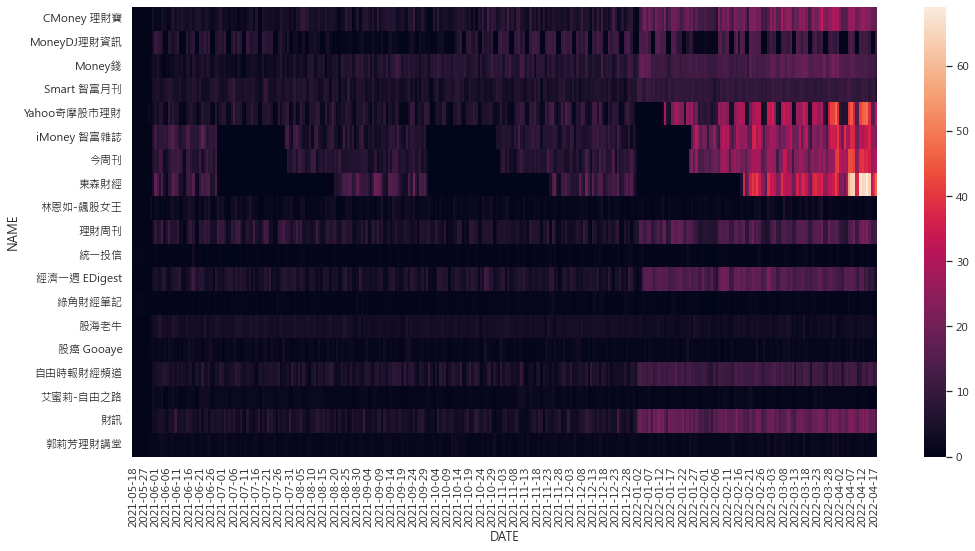

In [18]:
sns.heatmap(plotdf)

### 貼文數量與LIKE數 - scatter plot
- 初步檢視粉絲專頁的影響力

In [20]:
plotdf = df.groupby('NAME')['REACTION_COUNT'].describe()
plotdf

,count,mean,std,min,25%,50%,75%,max
NAME,,,,,,,,
CMoney 理財寶,2969.0,26.644325,82.779943,0.0,4.00,9.0,22.00,2776.0
MoneyDJ理財資訊,1754.0,53.045040,168.938482,1.0,14.00,23.0,36.00,3981.0
Money錢,2646.0,35.001890,137.573736,0.0,3.00,7.0,18.00,2420.0
Smart 智富月刊,2036.0,59.546169,95.554255,0.0,14.00,28.0,65.00,1564.0
Yahoo奇摩股市理財,3142.0,139.617441,558.543239,0.0,4.00,7.0,27.00,10406.0
iMoney 智富雜誌,3136.0,26.065370,97.235074,0.0,2.00,6.0,15.00,2517.0
今周刊,3134.0,354.775686,1189.612971,0.0,20.00,61.0,223.75,19862.0
東森財經,3231.0,1010.745280,4856.556203,0.0,18.00,53.0,211.50,87463.0
林恩如-飆股女王,491.0,372.556008,264.611803,30.0,177.50,319.0,476.50,2476.0


<AxesSubplot:xlabel='count', ylabel='50%'>

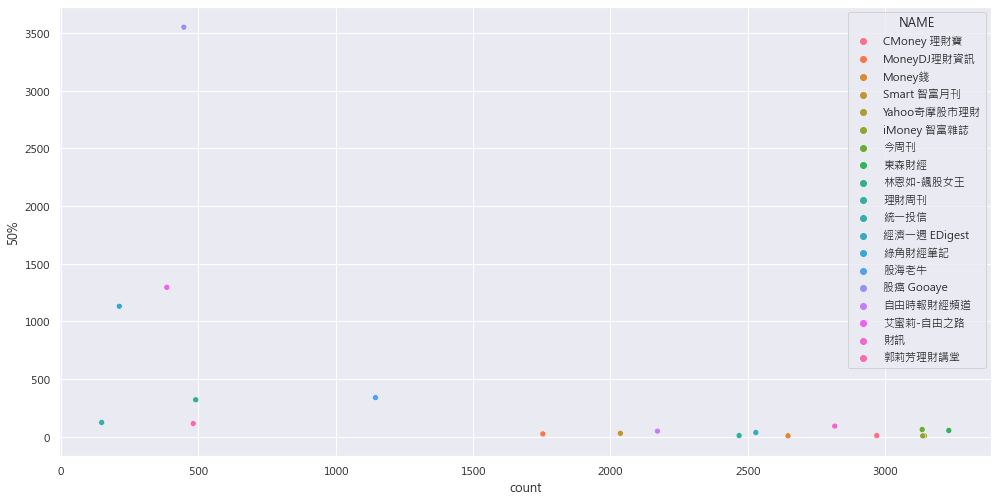

In [22]:
sns.scatterplot(x='count', y='50%', data=plotdf, hue='NAME')

### 貼文字數-Boxplot

In [23]:
# 不同粉絲頁的貼文字數
df['MESSAGE_LEN'] = df['MESSAGE'].apply(lambda x: len(x))
df.groupby('NAME')['MESSAGE_LEN'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
NAME,,,,,,,,,,,,,,
CMoney 理財寶,2969.0,80.430448,100.804272,10.0,29.0,34.0,38.0,42.2,49.0,55.0,67.0,89.0,161.0,1517.0
MoneyDJ理財資訊,1754.0,167.854048,80.092768,42.0,105.0,118.0,128.0,139.0,149.0,163.0,176.0,195.4,235.0,984.0
Money錢,2646.0,59.387755,67.254229,12.0,28.0,32.0,36.0,39.0,43.0,48.0,53.5,63.0,89.0,714.0
Smart 智富月刊,2036.0,86.888507,141.231668,3.0,10.0,13.0,17.0,24.0,32.0,43.0,62.0,117.0,236.0,1016.0
Yahoo奇摩股市理財,3142.0,39.633991,36.114621,3.0,15.0,21.0,25.0,28.0,32.0,36.0,40.0,47.0,62.0,388.0
iMoney 智富雜誌,3136.0,170.100128,171.065652,12.0,31.0,39.0,47.0,55.0,64.0,99.0,278.0,335.0,402.5,1547.0
今周刊,3134.0,106.267071,99.079664,10.0,31.0,41.0,50.0,62.0,74.0,89.0,109.0,154.0,224.0,982.0
東森財經,3231.0,54.873104,33.067657,9.0,25.0,28.0,33.0,51.0,55.0,58.0,61.0,66.0,88.0,511.0
林恩如-飆股女王,491.0,168.264766,176.693217,4.0,15.0,28.0,52.0,83.0,113.0,152.0,219.0,282.0,402.0,1696.0


<AxesSubplot:xlabel='MESSAGE_LEN', ylabel='NAME'>

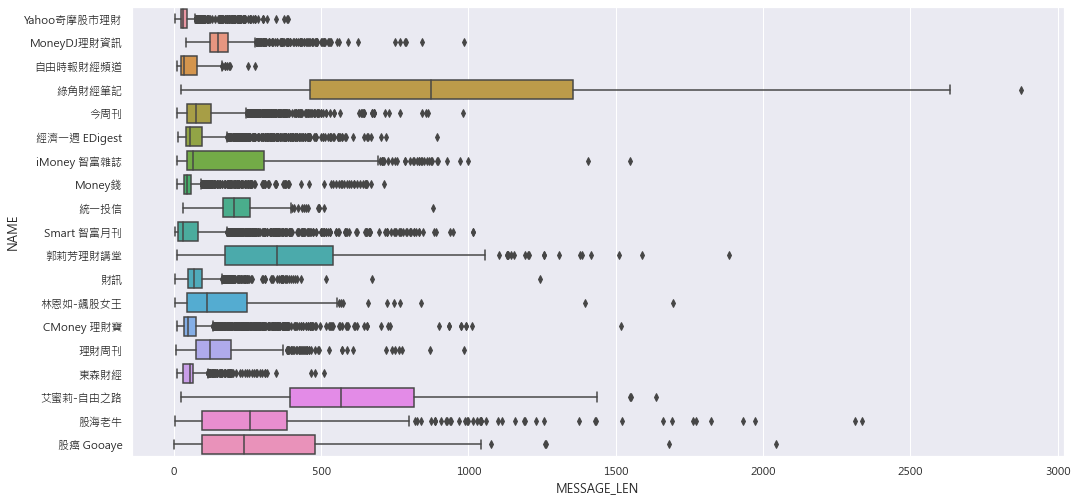

In [24]:
sns.boxplot(x='MESSAGE_LEN', y='NAME', data=df[['NAME', 'MESSAGE', 'MESSAGE_LEN']])

### 發文時段差異 - heatplot

In [25]:
# 發文的時段 by 分鐘
plotdf = df.groupby(['NAME', 'HOUR']).size().reset_index(name='CNT').pivot('NAME', 'HOUR', 'CNT').fillna(0)
plotdf

HOUR,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
NAME,,,,,,,,,,,,,,,,,,,,,
CMoney 理財寶,1.0,0.0,2.0,0.0,0.0,0.0,0.0,50.0,166.0,173.0,...,187.0,165.0,180.0,96.0,306.0,220.0,275.0,227.0,97.0,6.0
MoneyDJ理財資訊,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,21.0,167.0,...,127.0,128.0,130.0,119.0,143.0,149.0,154.0,74.0,6.0,1.0
Money錢,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,211.0,62.0,...,142.0,210.0,219.0,4.0,18.0,122.0,219.0,295.0,44.0,5.0
Smart 智富月刊,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,...,219.0,5.0,284.0,9.0,225.0,36.0,207.0,215.0,125.0,0.0
Yahoo奇摩股市理財,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,134.0,129.0,...,241.0,226.0,188.0,234.0,250.0,225.0,204.0,174.0,125.0,100.0
iMoney 智富雜誌,9.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,122.0,147.0,...,169.0,176.0,258.0,238.0,231.0,282.0,254.0,258.0,218.0,196.0
今周刊,3.0,0.0,1.0,0.0,0.0,0.0,2.0,64.0,141.0,188.0,...,235.0,208.0,193.0,206.0,211.0,212.0,201.0,186.0,189.0,97.0
東森財經,78.0,19.0,1.0,1.0,0.0,0.0,5.0,33.0,107.0,211.0,...,264.0,223.0,208.0,231.0,179.0,156.0,143.0,217.0,123.0,83.0
林恩如-飆股女王,9.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,28.0,37.0,...,31.0,23.0,23.0,61.0,27.0,22.0,51.0,49.0,17.0,19.0


<AxesSubplot:xlabel='HOUR', ylabel='NAME'>

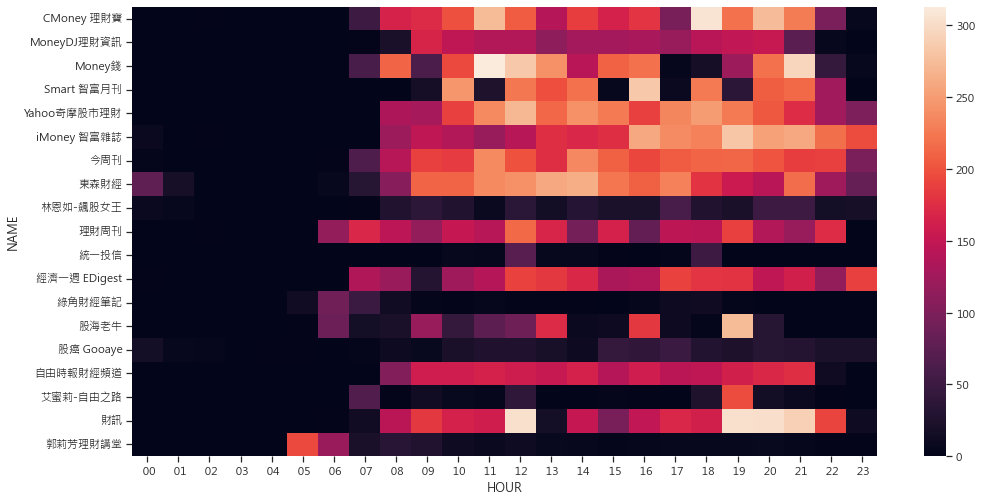

In [27]:
sns.heatmap(plotdf)

### 字數跟按讚數- Regplot, hue by name

In [36]:
plotdf = df[['NAME', 'MESSAGE_LEN', 'REACTION_COUNT']]
plotdf

,NAME,MESSAGE_LEN,REACTION_COUNT
0,Yahoo奇摩股市理財,21,402
1,Yahoo奇摩股市理財,36,16
2,Yahoo奇摩股市理財,31,22
3,Yahoo奇摩股市理財,28,26
4,Yahoo奇摩股市理財,28,5
...,...,...,...
35341,股癌 Gooaye,358,2118
35342,股癌 Gooaye,400,8222
35343,股癌 Gooaye,234,2800
35344,股癌 Gooaye,979,3761


In [37]:
plotdf['MESSAGE_LEN'] = np.log(plotdf['MESSAGE_LEN'])
plotdf['REACTION_COUNT'] = np.log(plotdf['REACTION_COUNT'])
plotdf

/tmp/ipykernel_15167/2436533190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdf['MESSAGE_LEN'] = np.log(plotdf['MESSAGE_LEN'])
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_15167/2436533190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdf['REACTION_COUNT'] = np.log(plotdf['REACTION_COUNT'])


,NAME,MESSAGE_LEN,REACTION_COUNT
0,Yahoo奇摩股市理財,3.044522,5.996452
1,Yahoo奇摩股市理財,3.583519,2.772589
2,Yahoo奇摩股市理財,3.433987,3.091042
3,Yahoo奇摩股市理財,3.332205,3.258097
4,Yahoo奇摩股市理財,3.332205,1.609438
...,...,...,...
35341,股癌 Gooaye,5.880533,7.658228
35342,股癌 Gooaye,5.991465,9.014569
35343,股癌 Gooaye,5.455321,7.937375
35344,股癌 Gooaye,6.886532,8.232440


/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/tlyu0419/pyenvs/venv/lib/python3.8/site-packages/numpy/lib/nanfuncti

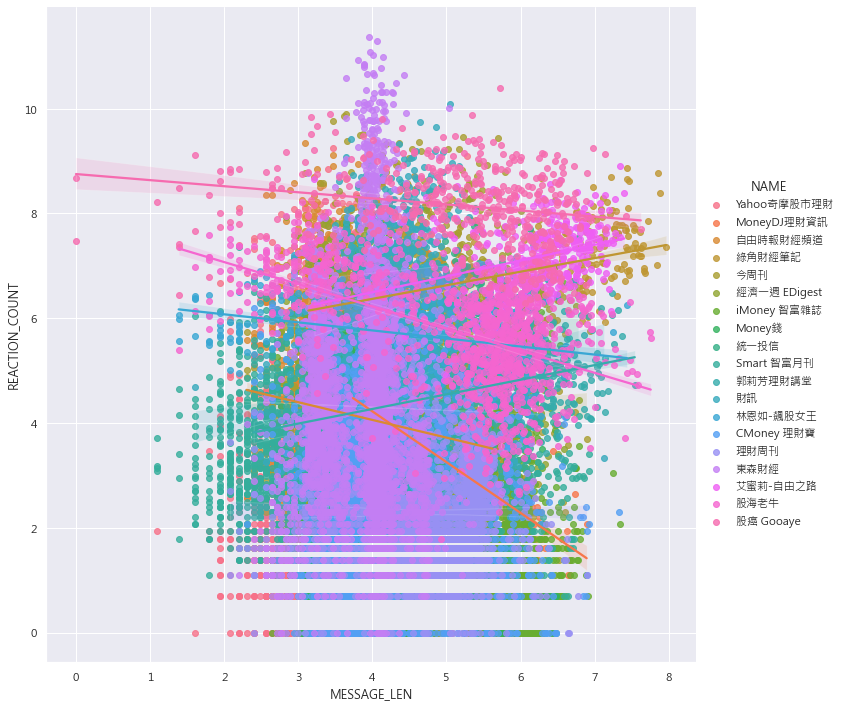

In [40]:
# sns.set(rc={'figure.figsize':(16, 16)})
sns.lmplot(x='MESSAGE_LEN', y='REACTION_COUNT', data = plotdf, hue='NAME', height=10)

## 斷詞器

### 手動新增
- jieba 的是詞庫是來自於1995年的人民日報訓練而得，一方面時間距今已久，另方面則是中國的語料庫，跟我們的習慣難免會不一樣，使用時可以適當的添加關鍵詞提升斷詞效果

In [41]:
sentence = df['MESSAGE'][9]
sentence

'中油宣布配合政府大宗物資降稅政策，今日起汽柴油價每公升降1.1元，95無鉛汽油降回30元....\n\n#油價 #降稅 #中油'

In [42]:
np.array(jieba.lcut(sentence))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.454 seconds.
Prefix dict has been built successfully.


array(['中油', '宣布', '配合', '政府', '大宗', '物資', '降稅', '政策', '，', '今日', '起',
       '汽柴油', '價每公', '升降', '1.1', '元', '，', '95', '無', '鉛', '汽油', '降回',
       '30', '元', '....', '\n', '\n', '#', '油價', ' ', '#', '降稅', ' ', '#',
       '中油'], dtype='<U4')

In [43]:
words = ['存股族', '資金', '瑞幸咖啡', '台中', '資產', '公開', '強強滾', '大盤', '覺得', '佈局', '宅女', '搶買', '投資', '上漲', '後悔', '房地產', 
         '以房養老', '留房養老', '殖利率', '佳世達', '公升', '無鉛汽油']
for word in words:
    jieba.add_word(word)

In [44]:
np.array(jieba.lcut(sentence))

array(['中油', '宣布', '配合', '政府', '大宗', '物資', '降稅', '政策', '，', '今日', '起',
       '汽柴油', '價每公', '升降', '1.1', '元', '，', '95', '無鉛汽油', '降回', '30', '元',
       '....', '\n', '\n', '#', '油價', ' ', '#', '降稅', ' ', '#', '中油'],
      dtype='<U4')

### ngram
- 手動新增字詞太累了，嘗試透過演算法幫我們找出新詞

In [45]:
df['PROC_MESSAGE'] = df['MESSAGE'].apply(lambda x: re.sub('[^\u4e00-\u9fa5]', '', x))
count_vect = CountVectorizer(ngram_range=(2,4), analyzer='char', max_features=50) # analyzer{‘word’, ‘char’, ‘char_wb’} or callable, default=’word’
bow_rep = count_vect.fit_transform(df['PROC_MESSAGE'])
count_vect.vocabulary_.keys()

dict_keys(['台股', '股票', '疫情', '怎麼', '理財', '可以', '股市', '美股', '台積', '積電', '台積電', '一個', '開始', '台灣', '什麼', '今年', '知道', '就是', '自己', '投資', '時間', '大家', '獲利', '金融', '股價', '因為', '美國', '沒有', '市場', '可能', '如何', '產業', '不是', '利率', '還是', '經濟', '中國', '全球', '指數', '分析', '我們', '公司', '香港', '免費', '一週', '濟一', '智富', '經濟一', '濟一週', '經濟一週'])

In [46]:
for word in count_vect.vocabulary_.keys():
    jieba.add_word(word)

In [47]:
df['PROC_MESSAGE'] = df['MESSAGE'].apply(lambda x: jieba.lcut(x))
df.head(3)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
0,Yahoo奇摩股市理財,2021-11-30 11:36:00,眼淚還來ＸＤＤＤ\n\n#ikea  #開幕,4561162900635616,114062348679049,22,402,9,20,AQHRnTN_PnSqfTFzH18_GeaXjyCT1LZ0K-PHIipkRlbo8j...,...,2,0,3,1,2022-04-18 21:08:08,2021-11-30,2021-11,11,21,"[眼淚, 還來, Ｘ, Ｄ, Ｄ, Ｄ, \n, \n, #, ikea, , , ,..."
1,Yahoo奇摩股市理財,2022-04-12 18:09:03,小編是沒錢抽綠界 但台股量縮所有股票都下跌 我也是受害者ㄋㄟ\n#YFR,4997955090289726,114062348679049,0,16,0,0,AQHR4tF-VlhjvD6PLeskWPfBgK0hYCwvAacuWYzWqWk00p...,...,0,0,0,0,2022-04-18 21:08:08,2022-04-12,2022-04,18,36,"[小編, 是, 沒, 錢, 抽綠界, , , 但, 台股, 量縮, 所有, 股票, 都,..."
2,Yahoo奇摩股市理財,2022-01-17 13:31:51,今天買進還有機會跟上喔!!快快衝一波\n#ETF #除息 #配息,4737106536374584,114062348679049,2,22,0,0,AQHROr-Ww30eJz52QDHRCJI5WooIqF0xbE6L_OzdTfQ1lF...,...,0,0,0,0,2022-04-18 21:08:08,2022-01-17,2022-01,13,31,"[今天, 買進, 還有, 機會, 跟上, 喔, !, !, 快快, 衝一波, \n, #, ..."


In [48]:
for sent in df['PROC_MESSAGE'][:5]:
    print(sent)
    print('====')

['眼淚', '還來', 'Ｘ', 'Ｄ', 'Ｄ', 'Ｄ', '\n', '\n', '#', 'ikea', ' ', '\x08', ' ', '#', '開幕']
====
['小編', '是', '沒', '錢', '抽綠界', ' ', ' ', '但', '台股', '量縮', '所有', '股票', '都', '下跌', ' ', '我', '也', '是', '受害者', 'ㄋ', 'ㄟ', '\n', '#', 'YFR']
====
['今天', '買進', '還有', '機會', '跟上', '喔', '!', '!', '快快', '衝一波', '\n', '#', 'ETF', ' ', '#', '除息', ' ', '#', '配息']
====
['23', '歲', '女友', '月領', '16', '萬', '\n', '未來', '公婆', '嫌棄', '！', '\n', '要', '她當', '「', '傳統', '媳婦', '」']
====
['電視台', '的', '工作', '出現', '問題', '，', '再', '加上', '疫情', '爆發', '，', '讓', '他', '收入', '瞬間', '歸', '零', '。']
====


## 情感分析

### 統計值法

In [49]:
df.groupby('DATE')[['LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']].sum()

,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
DATE,,,,,,,
2021-05-18,30,0,0,0,0,0,0
2021-05-20,30,0,0,0,0,0,0
2021-05-21,1662,3,24,0,5,1,0
2021-05-24,1058,0,19,0,0,0,0
2021-05-26,771,0,4,1,0,0,0
...,...,...,...,...,...,...,...
2022-04-14,80054,9636,989,1610,1210,619,253
2022-04-15,60520,8634,451,1869,222,343,259
2022-04-16,68885,8800,3096,2266,284,158,229


### 詞典法

#### 情感詞庫
- 哈大: 
  - https://github.com/ZaneMuir/DLUT-Emotionontology
  - 情感语料库的构建和分析 徐琳宏 ,林鸿飞 ,赵 晶
- 台大情感詞庫
  - http://rportal.lib.ntnu.edu.tw/bitstream/20.500.12235/80604/1/ntnulib_ja_A1021_4401_024.pdf
  - https://www.rdocumentation.org/packages/tmcn/versions/0.2-13/topics/NTUSD
  - https://rdrr.io/rforge/tmcn/
- 缺點是通用的情感詞典無法適用特定的情境

In [50]:
# NTUSD
neg_words = pd.read_csv('./sent_dict/NTUSD_traditional/NTUSD_negative_unicode.txt', header=None)[0].to_list()
print(neg_words[:30])
print('=============')
pos_words = pd.read_csv('./sent_dict/NTUSD_traditional/NTUSD_positive_unicode.txt', header=None)[0].to_list()
print(pos_words[:30])

['一下子爆發', '一下子爆發的一連串', '一巴掌', '一再', '一再叮囑', '一拳', '一般殺人罪', '一陣狂風', '一陣緊張', '一掌', '一團糟', '一摑', '一點點', '一蹶不振', '人事不省', '人為', '人為的', '入迷', '入迷的', '入迷的人', '刀刃', '刁難', '力盡', '匕首', '下地獄', '下垂', '下垂度', '下流', '下流的', '下降']
['一帆風順', '一帆風順的', '一流', '一致', '一致的', '了不起', '了不起的', '了解', '人性', '人性的', '人格高尚', '人格高尚的', '人情', '人情味', '入神', '入神的', '入迷', '入迷的', '上好', '上好的', '上等', '上等的', '口頭通過', '大方', '大方的', '大無畏', '大無畏的', '大量的', '大膽', '大膽的']


In [51]:
# 大連理工大學
sentment_keywords = pd.read_excel('./sent_dict/情感词汇本体/情感词汇本体.xlsx')
sentment_keywords.groupby('情感分类').head(2)

,词语,词性种类,词义数,词义序号,情感分类,强度,极性,辅助情感分类,强度.1,极性.1,Unnamed: 10,Unnamed: 11
0,脏乱,adj,1.0,1.0,NN,7,2,NaN,NaN,NaN,NaN,NaN
1,糟报,adj,1.0,1.0,NN,5,2,NaN,NaN,NaN,NaN,NaN
2,早衰,adj,1.0,1.0,NE,5,2,NaN,NaN,NaN,NaN,NaN
5,战祸,noun,1.0,1.0,ND,5,2,NC,5.0,2.0,NaN,NaN
7,折辱,noun,1.0,1.0,NE,5,2,NN,5.0,2.0,NaN,NaN
9,清峻,adj,1.0,1.0,PH,5,0,NaN,NaN,NaN,NaN,NaN
10,清莹,adj,1.0,1.0,PH,5,1,NaN,NaN,NaN,NaN,NaN
18,瑞雪,noun,1.0,1.0,PA,5,1,NaN,NaN,NaN,NaN,NaN
19,擅名,noun,1.0,1.0,PD,7,1,NaN,NaN,NaN,NaN,NaN
20,神采,adj,1.0,1.0,PA,5,1,PH,1.0,1.0,NaN,NaN


In [52]:
def sent_score(sent):
    pos_score = 0
    neg_score = 0
    for word in sent:
        if word in pos_words:
            pos_score = pos_score + 1
        if word in neg_words:
            neg_score = neg_score + 1
    return pos_score, neg_score

In [53]:
sentence = ['今天', '是', '一帆風順', '的', '一天', '因為', '我', '吃到', '一份', '上等', '的', '鮭魚']
sent_score(sent = sentence)

(2, 0)

In [54]:
sentence = ['我', '以為', '今天', '的', '天氣', '很好', '但', '現實', '給了我', '一拳']
sent_score(sent = sentence)

(1, 2)

#### 自定義關鍵詞
根據最常出現的詞來標資料即可

In [55]:
neg_words = ['跳空', '競爭', '懷疑', '庫存', '封城', '憂心']
pos_words = ['強勢', '傑出', '解決', '上漲']

In [56]:
sentence = ['台積電', '的', '股價', '強勢', '上漲', '但是', '上海', '的', '封城', '令人', '憂心']
sent_score(sent = sentence)

(2, 2)

### 套件法
- 英文的可以看NLTK
- 但是要留意準確度的問題，因為每個人要應用的場景不會完全相同

In [57]:
# NLTK
sentence = '''
It was one of the worst movies I've seen, despite good reviews. 
Unbelievably bad acting!! Poor direction. VERY poor production. 
The movie was bad. Very bad movie. VERY bad movie. VERY BAD movie. VERY BAD movie!
'''
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)

{'neg': 0.609, 'neu': 0.391, 'pos': 0.0, 'compound': -0.9921}

In [58]:
# SnowNLP
s = SnowNLP('這個東西真的很棒')
s.sentiments

0.8587303470185047

### 翻譯法

In [40]:
translator= Translator(from_lang='zh-TW', to_lang='en')
translation = translator.translate("對的事情做，不對的事情不要做")
print(translation)

Do the right thing, don't do the wrong thing


In [42]:
translator= Translator(from_lang='zh-TW', to_lang='en')
translation = translator.translate("最困難的不是面對挫折打擊，最困難的是面對各種挫折打擊，卻沒有失去對人世的熱情")
print(translation)

The hardest part is not to fight against setbacks, the hardest part is to fight all kinds of setbacks without losing enthusiasm for the world.


In [43]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(translation)

{'neg': 0.08, 'neu': 0.701, 'pos': 0.219, 'compound': 0.4847}

### 爬蟲法
- https://ai.baidu.com/tech/nlp_apply/sentiment_classify
- 註冊帳號可以體驗xx次，註冊時記得切換成英文模式才能用各國的手機號碼註冊
- 次数包售卖方式低至15元/万次
- Baidu
- Wiser AI Lab
- 騰訊
- Google

In [59]:
# wiser ai lab
url = 'https://www.wisers.ai/?api=ailab-demo-apilb.wisers.com:8000/senti/api/processtext'
data = {'text':'遭標普降評 俄瀕臨百年首見違約、威脅要告上法院',
        'model':'dl',
        'output_level':'subject',
        'show_scores':'true'}
resp = requests.post(url, json=data) 
resp.json()

{'docid': None,
 'is_successful': True,
 'message': '',
 'overall_res': {'sentiment': -1, 'sentiment_score': 0},
 'detail_res': []}

In [64]:
# Baidu 
url = 'https://ai.baidu.com/aidemo'
data = {'apiType': 'nlp', 
        'type': 'sentimentClassify',
        't1': '配置顶级，不解释，手机需要的各个方面都很完美'}
headers = {'Referer': 'https://ai.baidu.com/tech/nlp_apply/sentiment_classify'}
resp = requests.post(url, data=data, headers=headers) 
resp.json()

{'errno': 0,
 'msg': 'success',
 'data': {'log_id': '1410646981557599506',
  'text': '配置顶级，不解释，手机需要的各个方面都很完美',
  'items': [{'positive_prob': 0.999956,
    'confidence': 0.999901,
    'negative_prob': 4.44644e-05,
    'sentiment': 2}]}}

### 借模型法
- 百度
- 詢問是否有批次資料的api

In [6]:
# # !pip install baidu-aip
# from aip import AipNlp
# APP_ID = '25938061'
# API_KEY = 'UzqA7VEKAsuHK5GOxvgRmFuM'
# SECRET_KEY = 'xxxxxxxxxxxxxxxx'
# client = AipNlp(appId = APP_ID, apiKey=API_KEY, secretKey=SECRET_KEY)
# text = '對的事情做，不對的事情不要做'
# client.sentimentClassify(text)
# client.emotion(text)

{'items': [{'prob': 0.999936,
   'label': 'neutral',
   'subitems': [],
   'replies': []},
  {'prob': 6.36578e-05, 'label': 'pessimistic', 'subitems': [], 'replies': []},
  {'prob': 4.43924e-07, 'label': 'optimistic', 'subitems': [], 'replies': []}],
 'text': '對的事情做，不對的事情不要做',
 'log_id': 1513093663081421552}

### 模型法
- 收集資料 >> 標註資料 >> 訓練模型 >> 效度 >> 
- Key point: How to label data?

#### Label

In [ ]:
## 1=正向，-1=負向， 混合或其他的貼文就 0, 
sent_df = []
pos_cnt = 0
neg_cnt = 0
while True:
    print('Progess >> positive count: {}/10, negative count: {}/10'.format(pos_cnt, neg_cnt))
    rand = np.random.choice(df.shape[0])
    print(df['NAME'][rand])
    print(df['MESSAGE'][rand])
    sent = input('Sentiment Score: ')
    if sent == '1':
        sent_df.append([df['PROC_MESSAGE'][rand], sent])
        pos_cnt = pos_cnt + 1
        print(pos_cnt)
    if sent == '2':
        sent_df.append([df['PROC_MESSAGE'][rand], sent])
        neg_cnt = neg_cnt + 1
    if pos_cnt >= 10 & neg_cnt >= 10:
        break
    clear_output()
sent_df = pd.DataFrame(sent_df, columns=['PROC_MESSAGE', 'SENTIMENT'])
sent_df

#### Model building
- label 資料非常少很辛苦，改借用別的資料集
- https://spacy.io/api/cli#download
- https://spacy.io/usage/models#download-pip

In [65]:
sent_df = pd.read_excel('./data/GooglePlay_Comments.xlsx')
sent_df['SENTIMENT'] = sent_df['Sentimen'].apply(lambda x: int(re.findall('[0-9]{1,}', x)[0]))
sent_df['SENTIMENT2'] = np.select(condlist = [sent_df['SENTIMENT']>=4, sent_df['SENTIMENT']<=2, sent_df['SENTIMENT']==3], 
                                  choicelist = ['pos', 'neg', 'neu'])
sent_df

,Unnamed: 0,Name,Timestamp,Content,Sentimen,likecounts,SENTIMENT,SENTIMENT2
0,0,李宗翰,2020年6月29日,不錯,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
1,1,Ning Hsu,2020年6月29日,已經等了有一週了，還沒收到退費的簡訊通知，若我到銀行確認並無退費，那我會尋求法律幫助。（20...,獲評為 1 顆星 (滿分 5 顆星),13,1,neg
2,2,宋佳宸,2020年6月29日,還不錯，挺方便的,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
3,3,翁嘉雯,2020年6月29日,好,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
4,4,蔡曜安,2020年6月29日,系統說外送員還在路上，但是實際上卻已經到了，讓外送員等我下樓真的很不好意思！,獲評為 2 顆星 (滿分 5 顆星),0,2,neg
...,...,...,...,...,...,...,...,...
2795,2795,曾小倩,2020年5月26日,越來越爛 這兩個月就遇到三次訂單問題 1.之前訂購兩張訂單，有一張訂單店家根本沒收到，白白等...,獲評為 1 顆星 (滿分 5 顆星),123,1,neg
2796,2796,Dino Leong,2020年5月26日,送餐常出错: 1. 东西少送或送错人。 2. 送餐员要求小费。 3. 餐卷常不能用。 4. ...,獲評為 3 顆星 (滿分 5 顆星),0,3,neu
2797,2797,鬥魚寶寶,2020年5月26日,不錯,獲評為 5 顆星 (滿分 5 顆星),0,5,pos
2798,2798,郭咚咚,2020年5月26日,速度快，讚,獲評為 5 顆星 (滿分 5 顆星),0,5,pos


In [69]:
# pip install -U spacy
# python -m spacy download zh_core_web_md
import spacy
from sklearn import svm
nlp = spacy.load('zh_core_web_md')

In [70]:
train_x_vectors = [nlp(text).vector for text in sent_df['Content']]

clf_svm = svm.SVC(kernel='linear')

clf_svm.fit(train_x_vectors, sent_df['SENTIMENT2'])

SVC(kernel='linear')

In [80]:
test_x = ['還不錯，挺方便的', 
          '外送員真的很棒很用心，食物到手上的時候還是熱的',
          '不錯'
          
          '我覺得表現一般，跟對手的表現都一樣',
          '外送員的表現真的很優秀，把湯的灑到處都是',
          '真的很有效率耶，東西送到的時候都冷掉了',
          '有些外送員會擺臭臉，真的是沒禮貌',]
test_x_vectors = [nlp(text).vector for text in test_x]
clf_svm.predict(test_x_vectors)

array(['pos', 'pos', 'neg', 'neg', 'neg', 'neu'], dtype=object)

## EDA2

### 看情感分數變化
異常低/高的時候是不是有特殊的事件發生!

In [84]:
sentiment_df = df.loc[df['DATE']>='2022-01-01']
sentiment_df = sentiment_df.groupby('DATE')[['LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']].sum()

std = StandardScaler()
sentiment_df = pd.DataFrame(std.fit_transform(sentiment_df), columns = sentiment_df.columns, index=sentiment_df.index)
sentiment_df

,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
DATE,,,,,,,
2022-01-01,-1.288970,-0.835134,-0.444749,-0.344666,-0.756928,-0.321995,-0.428035
2022-01-02,-0.968893,-0.868954,-0.416565,-0.748873,-0.656234,-0.325413,-0.450404
2022-01-03,-0.642582,-0.732531,-0.391065,-0.635215,-0.605887,-0.320286,-0.440462
2022-01-04,-0.233872,-0.698996,-0.315013,-0.644019,-0.590783,-0.340794,-0.419336
2022-01-05,-0.659868,-0.803026,-0.395092,-0.608801,-0.608405,-0.340794,-0.383299
...,...,...,...,...,...,...,...
2022-04-14,0.788188,0.409225,-0.028698,0.414124,2.248781,0.688045,-0.152160
2022-04-15,0.199894,0.266238,-0.269381,0.621430,-0.238355,0.216351,-0.144704
2022-04-16,0.451818,0.289926,0.913905,0.939193,-0.082280,-0.099820,-0.181984


In [85]:
sentiment_df_stk = sentiment_df[['LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']].stack().reset_index()
sentiment_df_stk.columns = ['DATE', 'REACTION_TYPE', 'ZSCORE']
sentiment_df_stk['DATE'] = sentiment_df_stk['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
sentiment_df_stk

,DATE,REACTION_TYPE,ZSCORE
0,2022-01-01,LIKE,-1.288970
1,2022-01-01,HAHA,-0.835134
2,2022-01-01,LOVE,-0.444749
3,2022-01-01,WOW,-0.344666
4,2022-01-01,CARE,-0.756928
...,...,...,...
751,2022-04-18,LOVE,-0.400907
752,2022-04-18,WOW,-0.659227
753,2022-04-18,CARE,-0.547988
754,2022-04-18,ANGRY,-0.058803


<AxesSubplot:xlabel='DATE', ylabel='ZSCORE'>

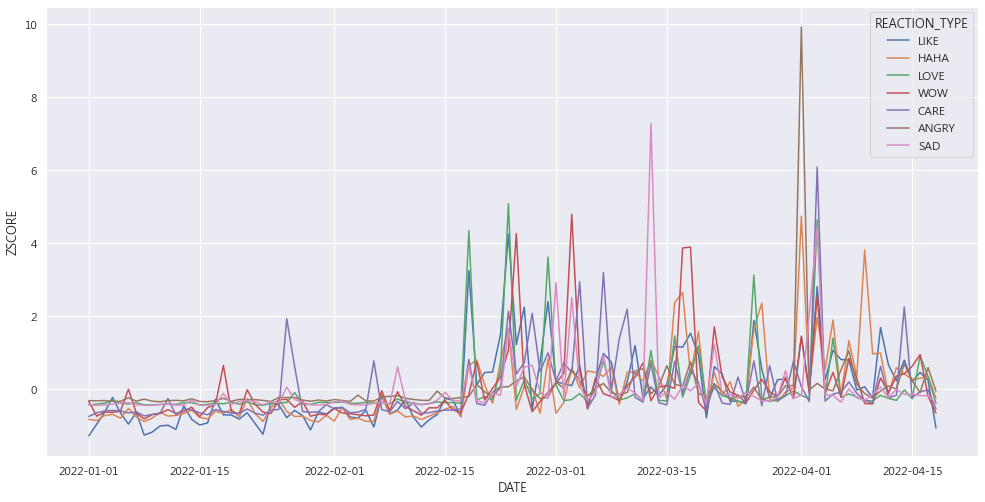

In [86]:
sns.set(rc={'figure.figsize':(16.7,8.27)})
sns.lineplot(x = 'DATE', y='ZSCORE', data=sentiment_df_stk, hue='REACTION_TYPE')

In [88]:
sentiment_df_stk.sort_values(['REACTION_TYPE', 'ZSCORE'], ascending= [True, False]).groupby('REACTION_TYPE').head(5)

,DATE,REACTION_TYPE,ZSCORE
635,2022-04-01,ANGRY,9.923670
677,2022-04-07,ANGRY,1.046942
537,2022-03-18,ANGRY,0.747861
726,2022-04-14,ANGRY,0.688045
516,2022-03-15,ANGRY,0.635065
648,2022-04-03,CARE,6.090248
459,2022-03-07,CARE,3.190267
438,2022-03-04,CARE,2.943568
725,2022-04-14,CARE,2.248781
480,2022-03-10,CARE,2.185847


In [63]:
# sentiment_df_stk.sort_values(['REACTION_TYPE', 'CNT'], ascending= [True, True]).groupby('REACTION_TYPE').head(5)

In [90]:
df.sort_values('ANGRY', ascending=False).head(1)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
21290,東森財經,2022-04-01 00:51:13,TACO編：比賽車比不過就比國力？\n杰尼龜嗆大陸就是規則！2min猛罵台友狂勸別衝動\n\...,4445191822249519,127254684043276,11594,30334,1229,9826,AQHR9UoGXRet0H9aBVIHXEYY9PU4x0ot56seJPT7LiZrgq...,...,5698,63,218,114,2022-04-18 18:41:03,2022-04-01,2022-04,00,62,"[TACO, 編, ：, 比賽車, 比不過, 就, 比國力, ？, \n, 杰尼龜, 嗆, ..."


In [91]:
df.sort_values('SAD', ascending=False).head(1)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
20150,東森財經,2022-03-13 09:45:00,愛在身編：心疼...既然選擇了牠就請伴牠一生！\n年邁阿金走不動遭棄！暖男照料50天助尊嚴離...,4396009263834442,127254684043276,622,18620,798,580,AQHRFhys-cS_AxvZcm83adAjrPsoLkRpPgX9vNalOQORKz...,...,42,6009,20,474,2022-04-18 18:41:03,2022-03-13,2022-03,09,64,"[愛在, 身編, ：, 心疼, ..., 既然, 選擇, 了, 牠, 就, 請, 伴, 牠,..."


In [92]:
df.sort_values('WOW', ascending=False).head(1)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
20799,東森財經,2022-03-18 20:45:00,真嗣拿你沒辦法編：糯米你還有什麼不會的🤣\n聰明汪教科書式顧娃！弟球掉水池1招驚險救\n\n...,4410863479015687,127254684043276,2794,43818,3182,2382,AQHRm6hIsCaP00mcfRaMa4nROf5Ow10Vo4EPD8oDEqqkGS...,...,11,13,4580,108,2022-04-18 18:41:03,2022-03-18,2022-03,20,55,"[真嗣, 拿, 你, 沒辦, 法編, ：, 糯米, 你, 還有, 什麼, 不會, 的, 🤣,..."


In [93]:
df.sort_values('HAHA', ascending=False).head(1)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
20733,東森財經,2022-04-09 18:45:01,在權志龍身編：真的是辛苦了～\n醫護爆笑催做核酸！喊下樓免化妝：這沒彭于晏\n\n影片來源：抖音,4467800656655302,127254684043276,4206,55773,9663,3116,AQHRm4Mt2StUT2JKgmZgsEWKhc1FxxJIIIuxPrvwPk57vE...,...,17,15,87,85,2022-04-18 18:41:03,2022-04-09,2022-04,18,45,"[在, 權志龍, 身編, ：, 真的, 是, 辛苦, 了, ～, \n, 醫護, 爆笑, 催..."


In [94]:
df.sort_values('LIKE', ascending=False).head(1)

,NAME,TIME,MESSAGE,POSTID,PAGEID,COMMENT_COUNT,REACTION_COUNT,SHARE_COUNT,DISPLAYCOMMENTCOUNT,CURSOR,...,ANGRY,SAD,WOW,CARE,UPDATETIME,DATE,YM,HOUR,MESSAGE_LEN,PROC_MESSAGE
20518,東森財經,2022-02-25 22:20:00,魅力無編：如果是你的孩子浪費食物，你會怎麼做？\n童浪費食物隨意扔！父1舉動獲讚最佳身教\n...,4355562004545835,127254684043276,3638,80843,4775,2911,AQHRUBsf1cqRa8N6TiS9VXz7ZsYtsqqyjtUS0_pZUCxBgI...,...,192,267,440,383,2022-04-18 18:41:03,2022-02-25,2022-02,22,58,"[魅力, 無編, ：, 如果, 是, 你, 的, 孩子, 浪費, 食物, ，, 你, 會, ..."


In [95]:
sentiment_df = df.groupby('DATE')[['LIKE', 'HAHA', 'LOVE', 'WOW', 'CARE', 'ANGRY', 'SAD']].sum()
sentiment_df

,LIKE,HAHA,LOVE,WOW,CARE,ANGRY,SAD
DATE,,,,,,,
2021-05-18,30,0,0,0,0,0,0
2021-05-20,30,0,0,0,0,0,0
2021-05-21,1662,3,24,0,5,1,0
2021-05-24,1058,0,19,0,0,0,0
2021-05-26,771,0,4,1,0,0,0
...,...,...,...,...,...,...,...
2022-04-14,80054,9636,989,1610,1210,619,253
2022-04-15,60520,8634,451,1869,222,343,259
2022-04-16,68885,8800,3096,2266,284,158,229


In [96]:
sentiment_df.to_pickle('./sentiment_by_date.pickle')